In [86]:
# Import libraries

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

In [87]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [88]:
# Get svhn dataset

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception('Data directory does not exist')
    
    
# Custom class to show download progress
class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile(data_dir + 'train_32x32.mat'):
    progressBar = DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN train dataset')
    urlretrieve(
        'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
        data_dir + 'train_32x32.mat',
        progressBar.hook
    )

if not isfile(data_dir + 'test_32x32.mat'):
    progressBar = DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN test dataset')
    urlretrieve(
        'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
        data_dir + 'test_32x32.mat',
        progressBar.hook
    )

In [89]:
# Load test and train set

train_set = loadmat(data_dir + 'train_32x32.mat')
test_set = loadmat(data_dir + 'test_32x32.mat')

In [90]:
idx = np.random.randint(0, train_set['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(train_set['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [91]:
# Scale images to match generator output

def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [92]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

In [93]:
# Model inputs

def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [94]:
def generator(_input, output_dim, reuse=False, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        ## Fully connected layer
        fully = tf.layers.dense(_input, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        fully = tf.reshape(fully, (-1, 4, 4, 512))
        # Apply batch normalization
        fully = tf.layers.batch_normalization(fully, training=is_training)
        # Apply leaky relu
        fully = tf.maximum(alpha * fully, fully)
        
        ## First deconvolution
        conv_1 = tf.layers.conv2d_transpose(fully, 256, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_training)
        # Apply leaky relu
        conv_1 = tf.maximum(alpha * conv_1, conv_1)
        
        ## Second deconvolution
        conv_2 = tf.layers.conv2d_transpose(conv_1, 128, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_training)
        # Apply leaky relu
        conv_2 = tf.maximum(alpha * conv_2, conv_2)
        
        ## Output deconvolution layer
        
        logits = tf.layers.conv2d_transpose(conv_2, output_dim, 5, strides=2, padding='same')
        return tf.tanh(logits)

In [95]:
def discriminator(_input, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        ## First convolution
        conv_1 = tf.layers.conv2d(_input, 64, 5, strides=2, padding='same')
        # Apply leaky relu without batch normalization
        conv_1 = tf.maximum(alpha * conv_1, conv_1)
        
        ## Second convolution
        conv_2 = tf.layers.conv2d(conv_1, 128, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        # Apply leaky relu
        conv_2 = tf.maximum(alpha * conv_2, conv_2)
        
        ## Third convolution
        conv_3 = tf.layers.conv2d(conv_2, 256, 5, strides=2, padding='same')
        # Apply batch normalization
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        # Apply leaky relu
        conv_3 = tf.maximum(alpha * conv_3, conv_3)
        
        ## Output fully connected layer and flatten it
        flat = tf.reshape(conv_3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [96]:
# Model loss

def model_loss(input_discriminator, input_generator, output_dim, alpha=0.2):
    ## Create genereator model
    generator_model = generator(
        input_generator,
        output_dim,
        alpha=alpha
    )
    
    ## Create discriminator real model
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_discriminator,
        alpha=alpha
    )
    
    ## Create discriminator fake model
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model,
        reuse=True,
        alpha=alpha
    )
    
    ## Get discriminator real loss
    discriminator_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real,
        labels=tf.ones_like(discriminator_model_real)
    )
    discriminator_loss_real = tf.reduce_mean(discriminator_loss_real)
    
    ## Get discriminator fake loss
    discriminator_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake,
        labels=tf.zeros_like(discriminator_model_fake)
    )
    discriminator_loss_fake = tf.reduce_mean(discriminator_loss_fake)
    
    ## Add discriminator losses
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    ## Get generator loss
    generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake,
        labels=tf.ones_like(discriminator_model_fake)
    )
    generator_loss = tf.reduce_mean(generator_loss)
    
    return discriminator_loss, generator_loss

In [97]:
# Optimizers

def model_optimizers(discriminator_loss, generator_loss, learning_rate, beta):
    ## Split trainable vars into generator and discriminator vars
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    ## Optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta
        ).minimize(discriminator_loss, var_list=discriminator_vars)
        
        generator_train = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta
        ).minimize(generator_loss, var_list=generator_vars)
    
    return discriminator_train, generator_train

In [98]:
# Build the model

class GAN:
    def __init__(self, discriminator_size, generator_size, learning_rate, alpha=0.2, beta=0.5):
        tf.reset_default_graph()
        
        self.input_discriminator, self.input_generator = model_inputs(
            discriminator_size,
            generator_size
        )
        
        self.discriminator_loss, self.generator_loss = model_loss(
            self.input_discriminator,
            self.input_generator,
            discriminator_size[2],
            alpha=alpha
        )
        
        self.discriminator_optimizer, self.generator_optimizer = model_optimizers(
            self.discriminator_loss,
            self.generator_loss,
            learning_rate,
            beta
        )

In [99]:
# Function to display generated images

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [100]:
# Training

def train(network, dataset, epochs, batch_size, print_every=10, show_every=100, fig_size=(5,5)):
    saver = tf.train.Saver()
    sample_generator = np.random.uniform(-1, 1, size=(72, generator_size))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                # Sample random noise for Generator
                batch_generator = np.random.uniform(-1, 1, size=(batch_size, generator_size))
                
                
                # Run optimizers
                feed_dict = {
                    network.input_discriminator: x,
                    network.input_generator: batch_generator
                }

                session.run(
                    network.discriminator_optimizer,
                    feed_dict=feed_dict
                )
                
                session.run(
                    network.generator_optimizer,
                    feed_dict=feed_dict
                )
                
                if steps % print_every == 0:
                    # Print losses at the end of each epoch
                    
                    train_loss_discriminator = network.discriminator_loss.eval(feed_dict)
                    train_loss_generator = network.generator_loss.eval({network.input_generator: batch_generator})
                    
                    print("Epoch {}/{}...".format(epoch + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator))
                    
                    # Save losses to view after training
                    losses.append((train_loss_discriminator, train_loss_generator))
                    
                if steps % show_every == 0:
                    generator_samples = session.run(
                        generator(network.input_generator, 3, reuse=True, is_training=False),
                        feed_dict={network.input_generator: sample_generator}
                    )
                    samples.append(generator_samples)
                    view_samples(-1, samples, 6, 12, figsize=fig_size)
                    plt.show()
        
        saver.save(session, './checkpoints/generator.ckpt')
        
    with open('samples.pkl', 'wb') as _file:
        pkl.dump(samples, _file)
        
    return losses, samples

In [ ]:

real_size = (32,32,3)
generator_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, generator_size, learning_rate, alpha=alpha, beta=beta1)

Epoch 1/25... Discriminator Loss: 0.9047... Generator Loss: 1.0209
Epoch 1/25... Discriminator Loss: 0.3475... Generator Loss: 1.8660
Epoch 1/25... Discriminator Loss: 0.1404... Generator Loss: 2.7024
Epoch 1/25... Discriminator Loss: 0.0971... Generator Loss: 3.1542
Epoch 1/25... Discriminator Loss: 0.1777... Generator Loss: 2.6645
Epoch 1/25... Discriminator Loss: 0.0890... Generator Loss: 3.0028
Epoch 1/25... Discriminator Loss: 0.0816... Generator Loss: 3.5226
Epoch 1/25... Discriminator Loss: 0.2091... Generator Loss: 2.7438
Epoch 1/25... Discriminator Loss: 0.7415... Generator Loss: 1.1728
Epoch 1/25... Discriminator Loss: 0.7964... Generator Loss: 1.7741


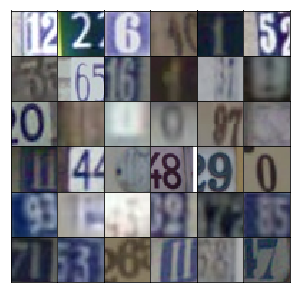

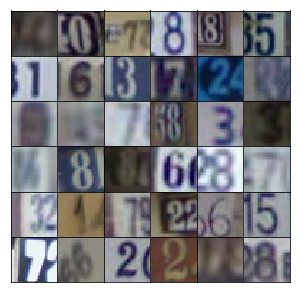

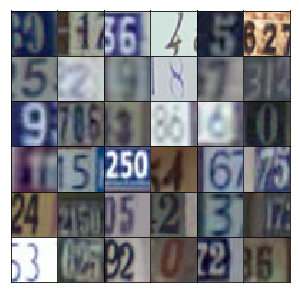

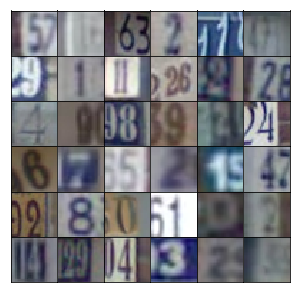

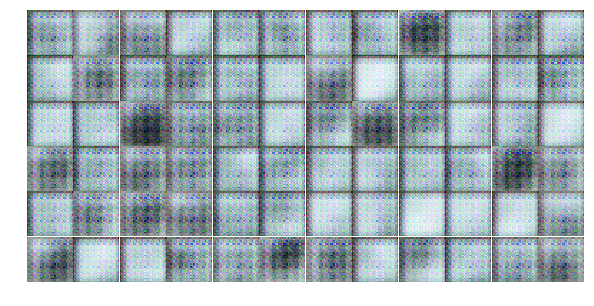

Epoch 1/25... Discriminator Loss: 0.5268... Generator Loss: 1.3821
Epoch 1/25... Discriminator Loss: 0.5848... Generator Loss: 1.4160
Epoch 1/25... Discriminator Loss: 0.4834... Generator Loss: 1.4963
Epoch 1/25... Discriminator Loss: 0.2192... Generator Loss: 2.8955
Epoch 1/25... Discriminator Loss: 0.4160... Generator Loss: 1.6336
Epoch 1/25... Discriminator Loss: 0.3306... Generator Loss: 3.0529
Epoch 1/25... Discriminator Loss: 0.1739... Generator Loss: 2.4079
Epoch 1/25... Discriminator Loss: 1.9101... Generator Loss: 0.6674
Epoch 1/25... Discriminator Loss: 3.4097... Generator Loss: 8.6009
Epoch 1/25... Discriminator Loss: 0.5605... Generator Loss: 1.2801


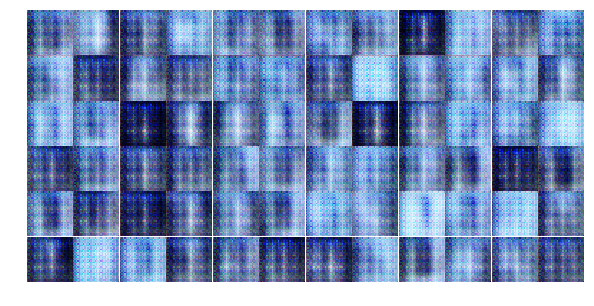

Epoch 1/25... Discriminator Loss: 0.4259... Generator Loss: 1.8389
Epoch 1/25... Discriminator Loss: 1.6947... Generator Loss: 4.3775
Epoch 1/25... Discriminator Loss: 0.3278... Generator Loss: 1.6945
Epoch 1/25... Discriminator Loss: 2.1263... Generator Loss: 0.1779


In [ ]:
dataset = Dataset(train_set, test_set)

losses, samples = train(net, dataset, epochs, batch_size, fig_size=(10,5))